# CNN 활용 TSR 검출

### import

In [1]:
import pickle, cv2
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
%matplotlib inline

### 학습 데이터 로드

In [2]:
with open('traffic-signs-data/train.p', mode='rb') as f:
    train = pickle.load(f)
with open('traffic-signs-data/valid.p', mode='rb') as f:
    valid = pickle.load(f)
with open('traffic-signs-data/test.p', mode='rb') as f:
    test = pickle.load(f)

### train, validation, test 세팅

In [3]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

### 이미지 normalize

In [4]:
def norm(image_data):
    return image_data / 255

### CLAHE (Contrast Limited Adaptive Histogram Equalization) 적용

In [5]:
X_train_gray = []
X_train_CLAHE = []
X_valid_gray = []
X_valid_CLAHE = []
X_test_gray = []
X_test_CLAHE = []

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
for i in range(n_train):
    X_train_gray.append(cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY))
    X_train_CLAHE.append(clahe.apply(X_train_gray[i]))
for i in range(n_validation):
    X_valid_gray.append(cv2.cvtColor(X_valid[i], cv2.COLOR_RGB2GRAY))
    X_valid_CLAHE.append(clahe.apply(X_valid_gray[i]))
for i in range(n_test):
    X_test_gray.append(cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY))
    X_test_CLAHE.append(clahe.apply(X_test_gray[i]))

### 데이터 평준화

In [6]:
X_train_arr = np.array(X_train_CLAHE)
X_valid_arr = np.array(X_valid_CLAHE)
X_test_arr = np.array(X_test_CLAHE)
X_train_arr = X_train_arr.reshape(X_train_arr.shape + (1,))
X_valid_arr = X_valid_arr.reshape(X_valid_arr.shape + (1,))
X_test_arr = X_test_arr.reshape(X_test_arr.shape + (1,))
X_train = norm(X_train_arr)
X_valid = norm(X_valid_arr)
X_test = norm(X_test_arr)

### CNN 설계

In [7]:
def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x96.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 96), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(96))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # pooling. Input = 32x32x96. Output = 16x16x96.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Layer 2: Convolutional. Output = 16x16x128.  
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 96, 128), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(128))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b 
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # pooling. Input = 16x16x128. Output = 8x8x128.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Layer 3: Convolutional. Output = 8x8x256.  
    conv3_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 128, 256), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(256))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b 
    # Activation.
    conv3 = tf.nn.relu(conv3)
    # pooling. Input = 8x8x256. Output = 4x4x256.  
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Layer 4: Convolutional. Output = 4x4x256.
    conv4_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 256, 256), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(256))
    conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='SAME') + conv4_b    
    # Activation.
    conv4 = tf.nn.relu(conv4)
    conv4 = tf.nn.dropout(conv4, keep_prob)
        
    # Flatten. Input = 4x4x256. Output = 4096.
    fc0   = flatten(conv4)
    
    # Layer 5: Fully Connected. Input = 4096. Output = 4096.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(4096, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 6: Fully Connected. Input = 4096. Output = 1024.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(512, 128), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(128))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 7: Fully Connected. Input = 1024. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43)) 
    logits    = tf.matmul(fc2, fc3_W) + fc3_b    
    
    return logits

### plot 차트

In [8]:
def plot_train(train_acc, valid_acc):
    fig, ax = plt.subplots()
    ax.plot(range(len(train_acc)), train_acc, label="Training Accuracy")
    ax.plot(range(len(valid_acc)), valid_acc, label="Validation Accuracy")
    
    ax.set_xlabel('Training epochs')
    ax.set_ylabel('Accuracy')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.05))
    plt.grid(True)
    plt.show()

### Training and Model Save

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training...

EPOCH 1: Training Accuracy = 0.348, Validation Accuracy = 0.607, Loss = 0.029

EPOCH 2: Training Accuracy = 0.849, Validation Accuracy = 0.865, Loss = 0.008

EPOCH 3: Training Accuracy = 0.965, Validation Accuracy = 0.913, Loss = 0.003

EPOCH 4: Training Accuracy = 0.987, Validation Accuracy = 0.948, Loss = 0.002

EPOCH 5: Training Accuracy = 0.994, Validation Accuracy = 0.950, Loss = 0.001

EPOCH 6: Training Accuracy = 0.997, Validation Accuracy = 0.955, Loss = 0.001

EPOCH 7: Training Accuracy = 0.998, Validation Accuracy = 0.953, Loss = 0.000

EPOCH 8: Training Accuracy = 0.998, Validation Accuracy = 0.968, Loss = 0.000

EPOCH 9: Training Accuracy = 0.999, Validation Accuracy = 0.970, Loss = 0.000

EPOCH 10: Training Accuracy = 0.999, Validation Accuracy = 0.971, Loss = 0.000



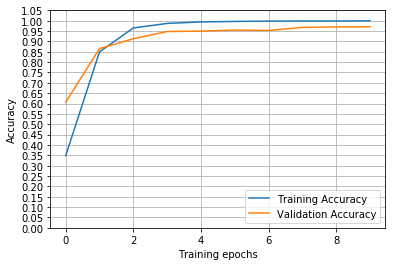

Model saved


In [9]:
EPOCHS = 10
BATCH_SIZE = 128
learning_rate = 0.0007

x = tf.placeholder(tf.float32, (None, 32, 32, 1),name='x')
y = tf.placeholder(tf.int32, (None),name='y')
one_hot_y = tf.one_hot(y, 43)    
keep_prob = tf.placeholder(tf.float32,name='keep_prob') # dropout

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy,name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Training...")
print()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc = []
    valid_acc = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_accuracy = 0
        total_loss = 0
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]                
            _,loss = sess.run([training_operation,loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
            total_loss += loss

        training_accuracy = total_accuracy/n_train
        train_acc.append(training_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_acc.append(validation_accuracy)
        
        print("EPOCH {}: Training Accuracy = {:.3f}, Validation Accuracy = {:.3f}, Loss = {:.3f}"
              .format(i+1,training_accuracy,validation_accuracy,total_loss/n_train))
        print()

    plot_train(train_acc, valid_acc)
    saver.save(sess, './model/Model_color_3ch')
    print("Model saved")

### Model load 후 test 확인

In [10]:
save_model_path = './model/Model_color_3ch'

with tf.Session() as sess:
    saver.restore(sess, save_model_path)

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/Model_color_3ch
Test Accuracy = 0.950
